# Assignment 5

This is an basecode for assignment 5 of Artificial Intelligence class (CSCE-4613), Spring 2025

In [ ]:
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms

from PIL import Image
import pickle
import matplotlib.pyplot as plt

## Question 1
### Define Input Transformation

In [ ]:
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]
IMAGE_SIZE = 224
image_transforms = transforms.Compose([
                           transforms.Resize(IMAGE_SIZE),
                           transforms.CenterCrop(IMAGE_SIZE),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = MEAN, std = STD)])

index2name = pickle.load(open("imagenet_class_names.pkl", "rb"))


### Define Model

In [ ]:
# model = torchvision.models.resnet50(pretrained=True) # Required for Problem 1
# model = torchvision.models.resnet101(pretrained=True) # Required for Problem 1
model = torchvision.models.densenet121(pretrained=True) # Required for Problem 1

softmax_layer = nn.Softmax(dim=1)
model.eval()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 151MB/s]


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

### Classify and Visualize Image

In [ ]:
# This is optional. It gets a random image from the internet and saves it to the file system.
!wget "https://cdn.pixabay.com/photo/2015/09/22/19/00/ship-952292_640.jpg"

--2025-04-18 02:12:22--  https://cdn.pixabay.com/photo/2015/09/22/19/00/ship-952292_640.jpg
Resolving cdn.pixabay.com (cdn.pixabay.com)... 172.64.147.160, 104.18.40.96, 2606:4700:4400::6812:2860, ...
Connecting to cdn.pixabay.com (cdn.pixabay.com)|172.64.147.160|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67037 (65K) [image/jpeg]
Saving to: ‘ship-952292_640.jpg’

ship-952292_640.jpg 100%[===================>]  65.47K  --.-KB/s    in 0.01s   

2025-04-18 02:12:22 (4.50 MB/s) - ‘ship-952292_640.jpg’ saved [67037/67037]



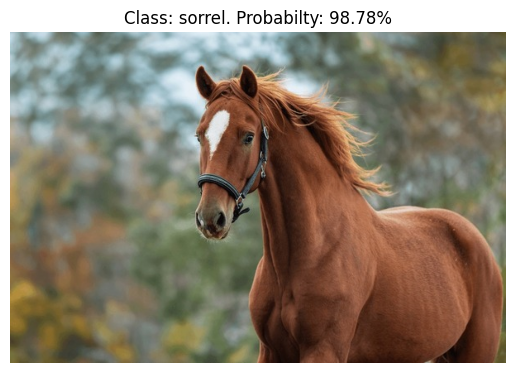

In [ ]:
image_path = "beautiful-horse-running-autumn-600nw-2430263853.jpg" # CHANGE THIS TO CHANGE THE IMAGE YOU WANT TO USE.
original_image = Image.open(image_path).convert("RGB")
image = image_transforms(original_image) # image size of 3 x H x W
image = image.unsqueeze(0)
# size of input into the network: B x 3 x H x W
output = softmax_layer(model(image))

prediction = torch.argmax(output, dim=1).item()
prob = output[0, prediction].item() * 100
predicted_name = index2name[prediction]

plt.imshow(original_image)
plt.title("Class: %s. Probabilty: %.2f" % (predicted_name, prob) + "%")
plt.axis("off")
plt.show()

### Get Top-K Predictions

In [ ]:
# Provides K-number of predictions the model decided upon.

K = 5

top_k_prob, top_k_index = torch.topk(output, K)
top_k_prob = top_k_prob.squeeze().detach().numpy()
top_k_index = top_k_index.squeeze().detach().numpy()
print(top_k_prob, top_k_index)
for score, idx in zip(top_k_prob, top_k_index):
  print("Class: %s. Probabilty: %.2f" % (index2name[idx], score * 100) + "%")
# Write your code to get the top-K predictions (top K classes that have highest probabilities)

[9.8783702e-01 1.5412528e-03 1.0203096e-03 9.7384775e-04 8.5674372e-04] [339 676 173 176 345]
Class: sorrel. Probabilty: 98.78%
Class: muzzle. Probabilty: 0.15%
Class: Ibizan hound, Ibizan Podenco. Probabilty: 0.10%
Class: Saluki, gazelle hound. Probabilty: 0.10%
Class: ox. Probabilty: 0.09%


## Question 2

### Define Training Data Loader

In [ ]:
train_batch_size = 32
train_dataset = torchvision.datasets.CIFAR10(
    root = "data/",
    transform = torchvision.transforms.ToTensor(),
    train = True,
    download = True
) # Define Training Set of CIFAR-10
train_loader = torch.utils.data.DataLoader(
    dataset = train_dataset,
    batch_size = train_batch_size,
    shuffle = True
) # Define Training Loader of CIFAR-10

100%|██████████| 170M/170M [00:03<00:00, 47.0MB/s]


In [ ]:
# OPTIONAL MODEL SHOWCASING HOW TO CREATE YOUR OWN INSTEAD OF USING
# TORCHVISION MODELS.

class ClassificationModel(torch.nn.Module):
  def __init__(self):
    super(ClassificationModel, self).__init__()
    self.num_classes = 10
    self.linear1 = nn.Linear(3 * 32 * 32, 1024)
    self.relu1 = nn.ReLU()
    self.linear2 = nn.Linear(1024, 512)
    self.relu2 = nn.ReLU()
    self.linear3 = nn.Linear(512, self.num_classes)

  def forward(self, x):
    n, c, h, w = x.size()
    x = x.reshape(n, -1)
    x = self.relu1(self.linear1(x))
    x = self.relu2(self.linear2(x))
    x = self.linear3(x)
    return x

### Define Model and Training Framework

Epoch [1/3]. Iter [1/1563]. Loss: 2.5233. Accuracy: 0.03
Epoch [1/3]. Iter [201/1563]. Loss: 2.0405. Accuracy: 0.06
Epoch [1/3]. Iter [401/1563]. Loss: 1.9539. Accuracy: 0.22
Epoch [1/3]. Iter [601/1563]. Loss: 1.8508. Accuracy: 0.16
Epoch [1/3]. Iter [801/1563]. Loss: 1.7932. Accuracy: 0.34
Epoch [1/3]. Iter [1001/1563]. Loss: 2.1504. Accuracy: 0.25
Epoch [1/3]. Iter [1201/1563]. Loss: 2.1884. Accuracy: 0.16
Epoch [1/3]. Iter [1401/1563]. Loss: 1.9052. Accuracy: 0.34
Epoch [2/3]. Iter [1/1563]. Loss: 1.4932. Accuracy: 0.44
Epoch [2/3]. Iter [201/1563]. Loss: 1.8474. Accuracy: 0.28
Epoch [2/3]. Iter [401/1563]. Loss: 1.3121. Accuracy: 0.56
Epoch [2/3]. Iter [601/1563]. Loss: 1.7464. Accuracy: 0.31
Epoch [2/3]. Iter [801/1563]. Loss: 1.5835. Accuracy: 0.41
Epoch [2/3]. Iter [1001/1563]. Loss: 1.1212. Accuracy: 0.59
Epoch [2/3]. Iter [1201/1563]. Loss: 1.0859. Accuracy: 0.66
Epoch [2/3]. Iter [1401/1563]. Loss: 1.5315. Accuracy: 0.50
Epoch [3/3]. Iter [1/1563]. Loss: 1.5590. Accuracy: 0.

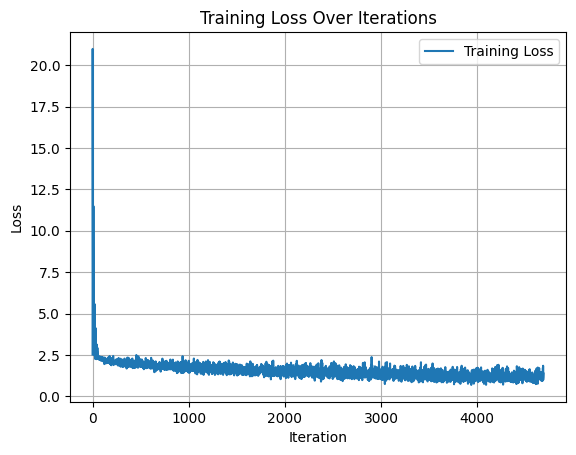

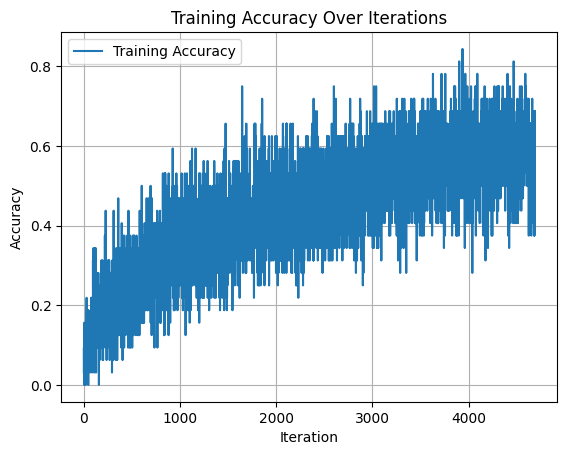

In [ ]:
cuda = torch.cuda.is_available() # Checks to see if GPU is available. If so, create a variable for it.
# model = ClassificationModel() # Define a classification model for 10 classes
model = torchvision.models.resnet18(num_classes = 10) # Define a classification model for 10 classes
if cuda:
  model.cuda() # Load the model into GPU memory to be used.

model.train() # Set the model to train
learning_rate = 0.05
num_epochs = 3
optim = torch.optim.Adam(model.parameters(), lr = learning_rate) # Uses ADAM instead of Stochastic Gradient Descent as the optimizer.
loss_fn = nn.CrossEntropyLoss()
loss_logger = []
accuracy_logger = []

for epoch in range(1, num_epochs + 1):
  for it, (images, labels) in enumerate(train_loader):
      if cuda:
        images = images.cuda()
        labels = labels.cuda()

      outputs = model(images)
      loss = loss_fn(outputs, labels)
      accuracy = (torch.argmax(outputs, dim=1) == labels).float().mean()
      optim.zero_grad()
      loss.backward()
      optim.step()


      loss_logger.append(loss)
      accuracy_logger.append(accuracy.item())

      if it % 200 == 0:
        print("Epoch [%d/%d]. Iter [%d/%d]. Loss: %0.4f. Accuracy: %.2f" % (epoch, num_epochs, it + 1, len(train_loader), loss, accuracy))

torch.save(model.state_dict(), "CIFAR10-Model.pth") # SAVE THE MODEL WITH THIS NAME TO BE USED IN THE NEXT STEP.

# Convert loss_logger from list of tensors to list of floats
losses = [loss.item() if torch.is_tensor(loss) else loss for loss in loss_logger]

# Plot training loss over iterations
plt.figure()
plt.plot(losses, label='Training Loss')
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Training Loss Over Iterations")
plt.legend()
plt.grid(True)
plt.show()

# Plot training accuracy over iterations
plt.figure()
plt.plot(accuracy_logger, label='Training Accuracy')
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.title("Training Accuracy Over Iterations")
plt.legend()
plt.grid(True)
plt.show()

### Load Model and Evaluate Model On Testing Dataset

In [ ]:
cuda = torch.cuda.is_available()
# MODEL *MUST* BE THE SAME AS DEFINED IN THE PREVIOUS STEP (resnet18).
model = torchvision.models.resnet18(num_classes = 10)# Define a classification model for 10 classes
if cuda:
  model.cuda()

# Load your trained model in the previous step
model.load_state_dict(torch.load("CIFAR10-Model.pth"))
model.eval()

test_dataset = torchvision.datasets.CIFAR10(
    root = "data/",
    transform = torchvision.transforms.ToTensor(),
    train = False,
    download = True
) # Define Testing Set of CIFAR-10
test_loader = torch.utils.data.DataLoader(
    dataset = test_dataset,
    batch_size = 1,
    shuffle = True
) # Define Testing Loader of CIFAR-10

final_accuracy = 0.0
final_top_5_accuracy = 0.0

logs = []
y_preds = []
y_labels = []

for it, (images, labels) in enumerate(test_loader):
  if cuda:
    images = images.cuda()
    labels = labels.cuda()

    outputs = model(images)
    top_5_accuracy = (torch.topk(outputs, 5)[1] == labels.view(-1, 1)).any(dim=1).float().mean()
    accuracy = (torch.argmax(outputs, dim=1) == labels).float().mean()

    if accuracy == 1:
      logs.append([images.cpu().detach().numpy(), labels.cpu().detach().numpy(), outputs.cpu().detach().numpy()])

    y_preds.append(torch.argmax(outputs, dim=1).item())
    y_labels.append(labels.item())

    final_accuracy += accuracy
    final_top_5_accuracy += top_5_accuracy

  if it % 500 == 0:
    print("Iter [%d/%d]. Accuracy: %.2f" % (it + 1, len(test_loader), accuracy))

print("Final Accuracy: %0.2f" % (final_accuracy / len(test_loader)))
print("Top 5 Accuracy: %0.3f" % (final_top_5_accuracy / len(test_loader)))

from sklearn.metrics import confusion_matrix

print("\n")

# Write your code to visualize the confusion matrix
print("Confusion Matrix for Model:")
print(confusion_matrix(y_labels, y_preds)) # CONFUSION MATRIX



Iter [1/10000]. Accuracy: 0.00
Iter [501/10000]. Accuracy: 1.00
Iter [1001/10000]. Accuracy: 1.00
Iter [1501/10000]. Accuracy: 0.00
Iter [2001/10000]. Accuracy: 1.00
Iter [2501/10000]. Accuracy: 1.00
Iter [3001/10000]. Accuracy: 1.00
Iter [3501/10000]. Accuracy: 1.00
Iter [4001/10000]. Accuracy: 1.00
Iter [4501/10000]. Accuracy: 0.00
Iter [5001/10000]. Accuracy: 1.00
Iter [5501/10000]. Accuracy: 1.00
Iter [6001/10000]. Accuracy: 1.00
Iter [6501/10000]. Accuracy: 1.00
Iter [7001/10000]. Accuracy: 0.00
Iter [7501/10000]. Accuracy: 0.00
Iter [8001/10000]. Accuracy: 1.00
Iter [8501/10000]. Accuracy: 0.00
Iter [9001/10000]. Accuracy: 0.00
Iter [9501/10000]. Accuracy: 1.00
Final Accuracy: 0.59
Top 5 Accuracy: 0.930


Confusion Matrix for Model:
[[749  20  86  27  39   8  22   0  17  32]
 [ 34 696   5  30   8   7  59   0   7 154]
 [ 86   3 555  30 104 112  94   6   1   9]
 [ 28   4 127 173  98 433 127   5   0   5]
 [ 27   1 132  68 630  59  60  21   1   1]
 [ 23   0 126  72  54 671  34  18   

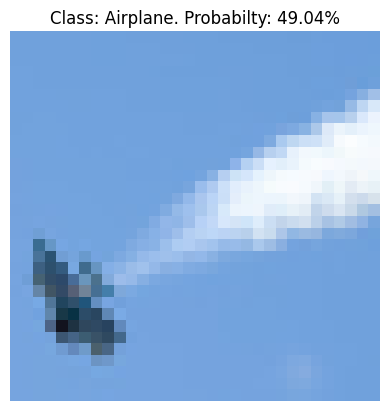

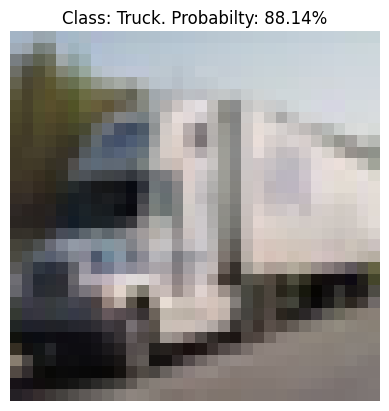

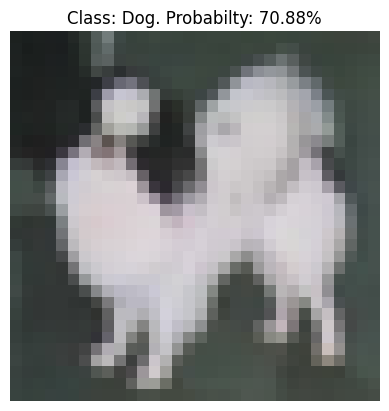

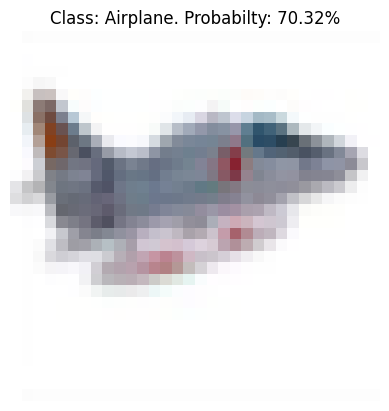

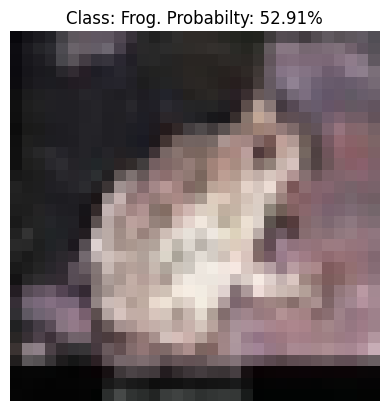

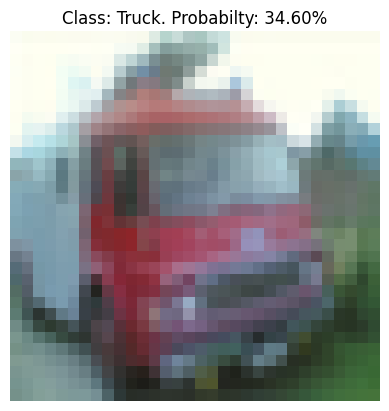

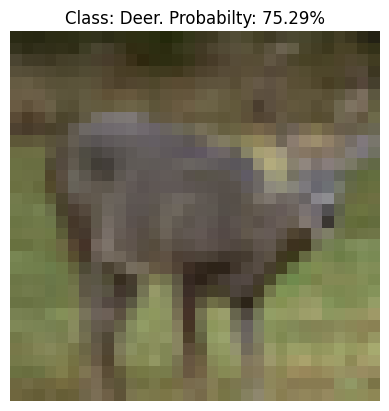

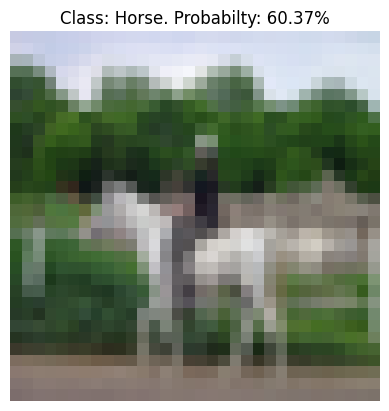

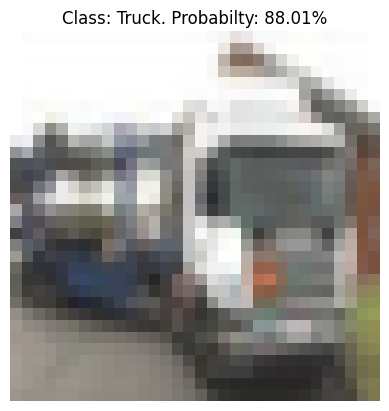

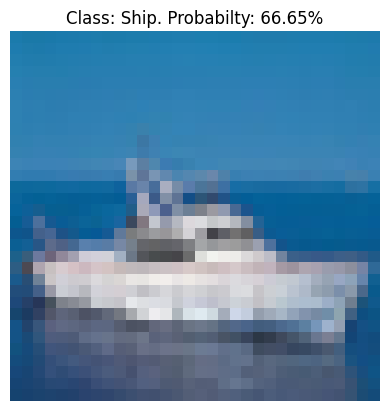

In [ ]:
import numpy as np


index2name = ["Airplane", "Automobile", "Bird", "Cat", "Deer", "Dog", "Frog", "Horse", "Ship", "Truck",]

softmax_layer = nn.Softmax(dim=1)

# image, label, output = logs[0]
#probs = F.softmax(torch.tensor(output), dim=1).numpy()  # Convert logits to probabilities
count = 0
for image, label, output in logs:
  if count == 10:
    break
  count += 1
  output = softmax_layer(torch.tensor(output))

  pred = np.argmax(output, axis = 1)
  # print(pred, label)
  # print(image.shape, label.shape, output.shape)
  image = image[0].transpose(1, 2, 0) * 255
  image = image.astype(np.uint8)

  plt.figure()
  plt.imshow(image)
  plt.title("Class: %s. Probabilty: %.2f" % (index2name[pred[0]], output[0, pred[0]] * 100) + "%")
  plt.axis("off")
  plt.show()